In [1]:
import os
print(os.getcwd())
os.chdir('/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1')
print(os.getcwd())

/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1/src/clustering
/Users/boyuren/Documents/multi_head_graph_rag/MH-GRAG-V1


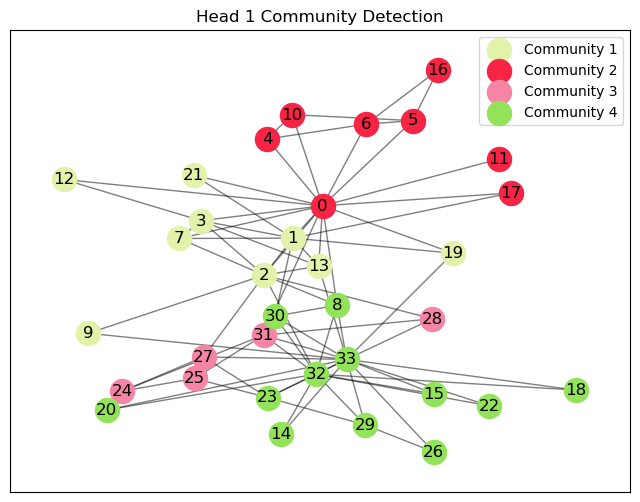

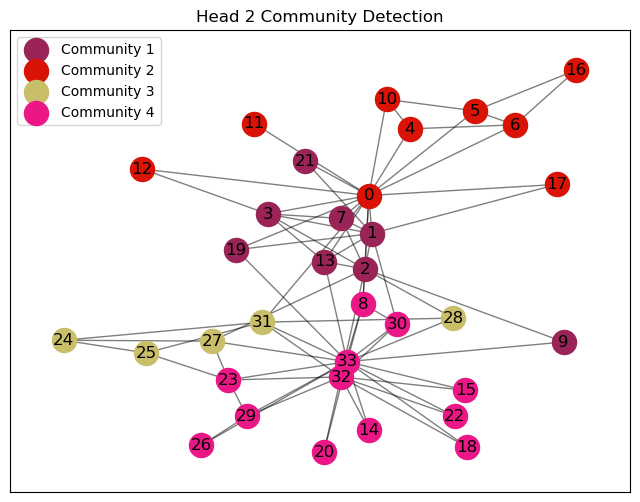

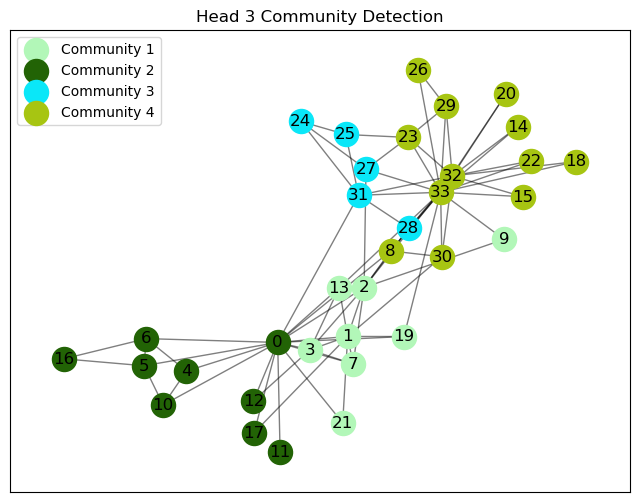

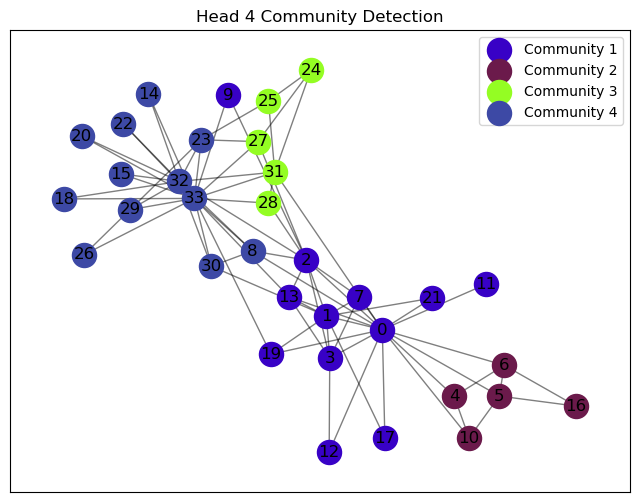

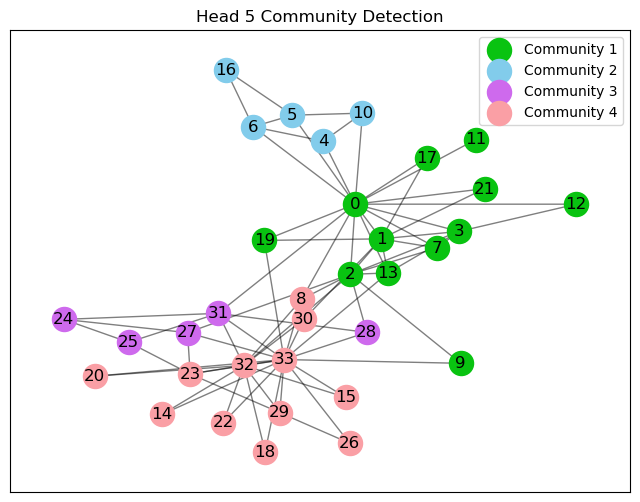

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from src.clustering.leiden import multi_head_leiden_with_mutual_info
from src.clustering.quality_functions import Modularity
# 创建一个示例图
G = nx.karate_club_graph()

# 定义质量函数
quality_function = Modularity(1)

# 设置多头机制的参数
num_heads = 5
λ = 0.1  # 互信息正则化权重
θ = 0.3  # Leiden 算法中的 θ 参数
γ = 0.05  # Leiden 算法中的 γ 参数

# 调用多头聚类函数
partitions = multi_head_leiden_with_mutual_info(G, quality_function, num_heads, λ, θ, γ)

# 绘制每个头的社区划分
for i, partition in enumerate(partitions):
    # 获取社区划分
    communities = partition.communities
    pos = nx.spring_layout(G)  # 使用 spring 布局来绘制图形

    # 给每个社区分配一个颜色
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in communities]

    plt.figure(figsize=(8, 6))
    plt.title(f"Head {i+1} Community Detection")

    # 为每个社区分配节点颜色
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=color, label=f"Community {list(communities).index(community)+1}")
    
    # 画出节点之间的边
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # 显示节点标签
    nx.draw_networkx_labels(G, pos)
    
    plt.legend(loc="best")
    plt.show()


Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv
Results appended to leiden_parallel_log.csv


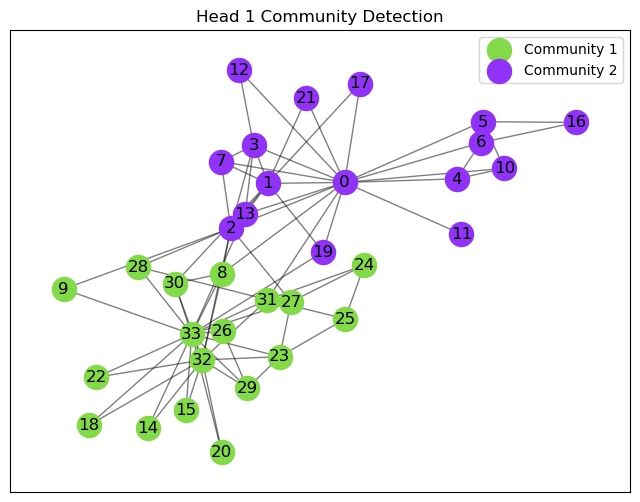

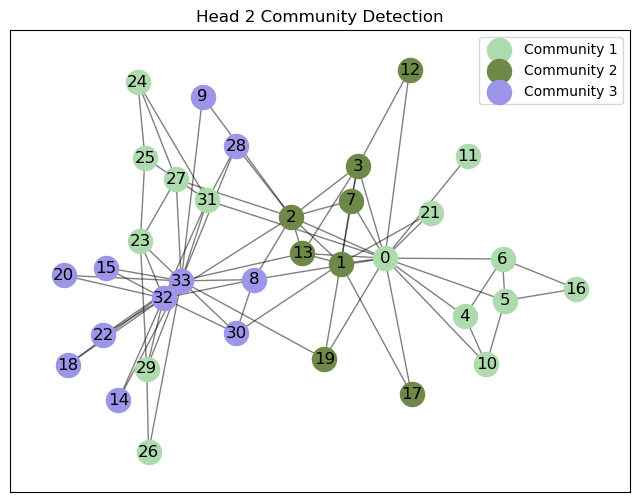

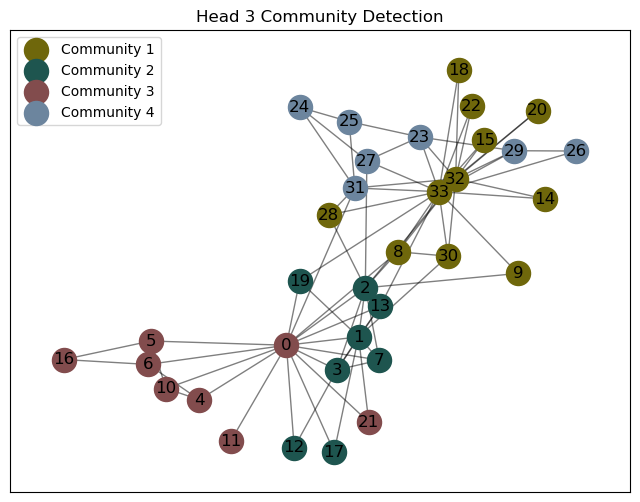

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from src.clustering.leiden_parallel import multi_head_leiden_with_mutual_info_parallel
from src.clustering.quality_functions import Modularity
# 创建一个示例图
G = nx.karate_club_graph()

# 定义质量函数
quality_function = Modularity(1)

# 设置多头机制的参数
num_heads = 3
λ = 0.1  # 互信息正则化权重
θ = 0.3  # Leiden 算法中的 θ 参数
γ = 0.05  # Leiden 算法中的 γ 参数

# 调用多头聚类函数
partitions = multi_head_leiden_with_mutual_info_parallel(G, quality_function, num_heads, λ, θ, γ)

# 绘制每个头的社区划分
for i, partition in enumerate(partitions):
    # 获取社区划分
    communities = partition.communities
    pos = nx.spring_layout(G)  # 使用 spring 布局来绘制图形

    # 给每个社区分配一个颜色
    colors = [f"#{random.randint(0, 0xFFFFFF):06x}" for _ in communities]

    plt.figure(figsize=(8, 6))
    plt.title(f"Head {i+1} Community Detection")

    # 为每个社区分配节点颜色
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=list(community), node_color=color, label=f"Community {list(communities).index(community)+1}")
    
    # 画出节点之间的边
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # 显示节点标签
    nx.draw_networkx_labels(G, pos)
    
    plt.legend(loc="best")
    plt.show()


In [2]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from src.clustering.leiden_parallel_gnn import GCNLeiden
from src.clustering.quality_functions import Modularity

# 定义质量函数
quality_function = Modularity(1)

# 1. 准备图和节点特征数据
G = nx.karate_club_graph()  # 使用Karaté图示例

# 为所有边添加默认的权重，如果没有定义权重
for u, v in G.edges:
    G[u][v]['weight'] = 1  # 默认权重为1

num_features = 34  # 假设每个节点有34个特征

# 构建节点特征（随机特征）
x = torch.randn((G.number_of_nodes(), num_features))

# 转换为 torch_geometric 格式
data = from_networkx(G)
data.x = x  # 将随机生成的特征赋予图的节点

# 2. 初始化Leiden GCN模型
num_heads = 3  # 使用3个Leiden分区头
model = GCNLeiden(in_channels=num_features, out_channels=16, num_heads=num_heads)

# 3. 定义质量函数（模块度）
𝓗 = quality_function

# 4. 定义优化器和训练过程
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练模型
for epoch in range(100):  # 假设训练100个epoch
    model.train()
    optimizer.zero_grad()

    # 前向传播
    x_out = model(data.x, data.edge_index, G, 𝓗, weight='weight')
    
    # 计算损失（模块度损失）
    loss = model.loss_fn(G, 𝓗)
    
    # 反向传播并优化
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# 5. 获取聚类结果
partitions = model.partitions  # 获取多头Leiden的社区划分结果

# 6. 可视化聚类结果
# 由于我们有多个头的分区，可以选择第一个头进行可视化
partition = partitions[0]  # 选择第一个头的社区划分

# 绘制社区划分图
colors = [partition._node_part[node] for node in G.nodes]  # 根据社区划分为每个节点赋予颜色

plt.figure(figsize=(8, 6))
nx.draw(G, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.title('Leiden-based Community Detection on Karate Club Graph')
plt.show()


KeyError: None